In [315]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
from skimage.segmentation import quickshift, slic, mark_boundaries

Notebook run using keras: 2.2.4


## Using Inception

Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [380]:
def transform_img(path_list):
    """ preprocess image to feed to the network """
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

Let us upload some image, feed it to pretrained NN (here InceptionV3) and look at the top 5 predicted classes. Here we print "label #", which is the number further given to the LIME explainer.

label # 250, class: Siberian_husky , prob=0.4441
label # 248, class: Eskimo_dog , prob=0.3125
label # 249, class: malamute , prob=0.1026
label # 174, class: Norwegian_elkhound , prob=0.0111
label # 270, class: white_wolf , prob=0.0069


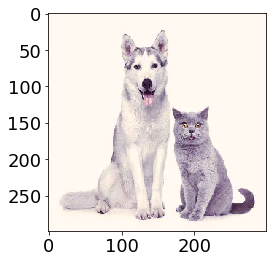

In [510]:
images = transform_img(['./cat_dog4.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
sorted_labels = np.argsort(-preds[0])
for label,x in zip(sorted_labels, decode_predictions(preds, top=5)[0]):
    print('label # %s,' % label, 'class:', x[1], ', prob=%.4f' % x[2])

## Explanation with lime

In [537]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [538]:
import lime_sk
import image_processing2

Here we need to choose class we want to explain. Fix the label number according to the above output.

In [539]:
label = 250

We are free to choose the kernel_width, which is used in weighted loss to estimate weights for the newly generated samples. 

In [540]:
explainer_lime_sk = image_processing2.ImageExplainer(label=label, kernel_width=0.5, random_state=42)

In [542]:
%%time
explanation_lime_slic = explainer_lime_sk.explain_prediction(images[0], inet_model.predict, 
                                                             num_samples=1000, 
                                                             segmentation='slic')

CPU times: user 14min 41s, sys: 2min 12s, total: 16min 53s
Wall time: 5min 18s


In [543]:
explanation_lime_slic.score

0.6247565224581564

In [547]:
total_number_of_features = np.unique(explanation.segments).shape[0]
total_number_of_features

89

## Now let's see the explanation for the top class (siberian husky)

In [548]:
explanation = explanation_lime_slic

Let's see the most significant superpixels for the class prediction. We mark with green color those which give positive contribution to the class prediction and with red color those, which give negative contribution.

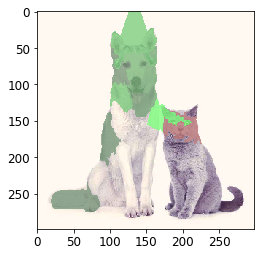

In [549]:
plt.rcParams.update({'font.size': 12})
temp, mask = explanation.get_image_and_mask(positive_only=False, num_features=10, hide_rest=False)
plt.imshow((images[0]/2 + 0.5), alpha=1)
plt.imshow((temp/2 + 0.5), alpha=0.8)

Here we plot only positive contributions, removing all other superpixels from image.

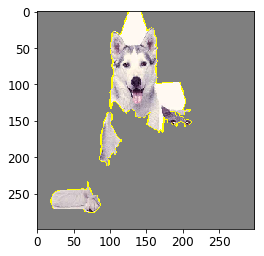

In [550]:
temp, mask = explanation.get_image_and_mask(positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We ca also put some threshold to the weight value and see what is left. Here we plot the pros and cons that have weight at least 0.1

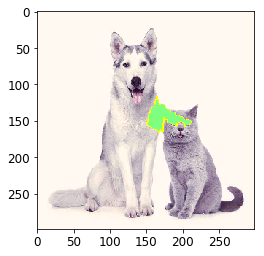

In [551]:
temp, mask = explanation.get_image_and_mask(positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## How to choose input parameter for LIME explainer?

## Check kernel width

Let us check how the r2 score changes with kernel width (remember: the higher the kernel width is, the more data samples give essential contribution to the loss.)

In [557]:
kernel_ws = [0.1, 0.25, 0.5, 0.75, 1., 1.5, 2., 5., 10.]

In [558]:
score_kw = []
for kw in kernel_ws:
    explainer_lime_sk = image_processing2.ImageExplainer(label=label, kernel_width=kw, random_state=42)
    explanation_lime_sk = explainer_lime_sk.explain_prediction(images[0], inet_model.predict, num_samples=1000)
    score_kw.append(explanation_lime_sk.score)

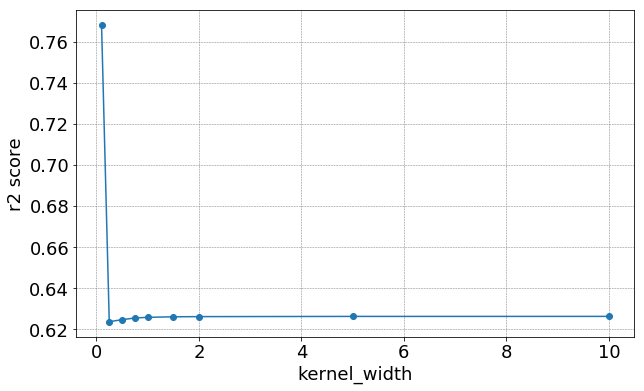

In [559]:
fig = plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})

plt.xlabel('kernel_width')
plt.ylabel('r2 score')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.plot(kernel_ws, score_kw, 'o-')

plt.legend()

## Check number of samples

Let us also check how the r2 score changes with number of samples generated to train explanation model.

In [449]:
n_samples = [100, 500, 700, 1000, 3000]

In [452]:
score_n = []
for n in n_samples:
    explainer_lime_sk = image_processing2.ImageExplainer(label=label, kernel_width=0.5, random_state=42)
    explanation_lime_sk = explainer_lime_sk.explain_prediction(images[0], inet_model.predict, num_samples=n)
    score_n.append(explanation_lime_sk.score)

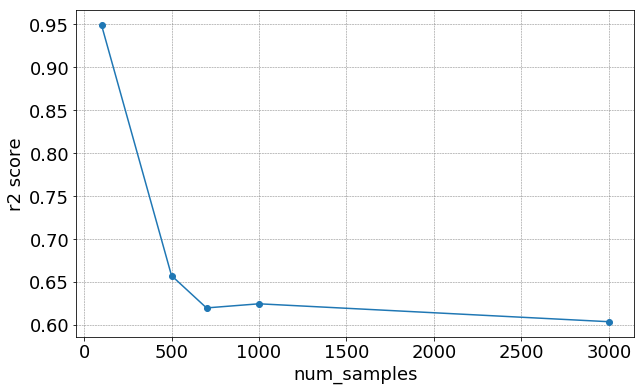

In [494]:
fig = plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})

plt.xlabel('num_samples')
plt.ylabel('r2 score')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.plot(n_samples, score_n, 'o-')

plt.legend()

## Check number of features

In [534]:
num_features = [1, 3, 5, 10, 20, 30]

In [535]:
score_features = []
for n in num_features:
    explainer_lime_sk = image_processing2.ImageExplainer(label=label, kernel_width=0.5, random_state=42)
    explanation_lime_sk = explainer_lime_sk.explain_prediction(images[0], inet_model.predict, 
                                                               num_samples=700, num_features=n)
    score_features.append(explanation_lime_sk.score)

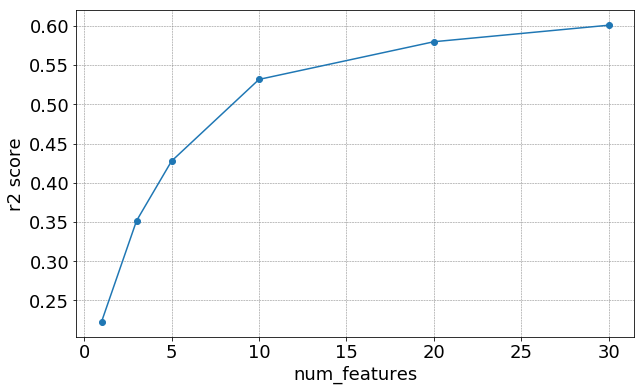

In [536]:
fig = plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})

plt.xlabel('num_features')
plt.ylabel('r2 score')
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.plot(num_features, score_features, 'o-')

plt.legend()

In [ ]:
()